# Assignment 4 
*by Sharanya Saha, 2111056*
<br> sharanya21@iitk.ac.in

Use any additional libraries you want, but if you don't explicitly code stuff that I have explicitly asked you to code, you will not get marks.

### Q1. Kernel k-means

Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [1]:
import random as rd

In [2]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt


def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [3]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

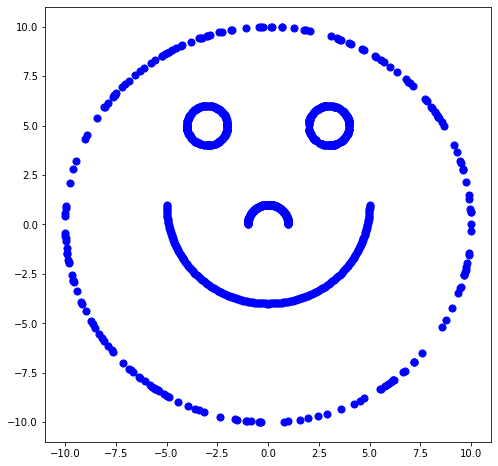

In [4]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = 'b', marker = 'o' )

(a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. [10 points] 

**Convergence Criteria:** <br>
If the difference between the loss (within cluster sum of squares between the centroid and the points) between two consecutive iterations is less than the tolerance value, then the algorithm is assumed to have converged.
$$
Loss: \sum_{k=1}^{K} \ \sum_{n: z_{n}=k} (x_{n}-\mu_{k})^{2} $$

In [5]:
#This is used to calculate the loss after clustering
def cal_loss(Output,Centroids) :
    centroids=Centroids.T
    loss=0
    for k in range(K):
        loss+=np.sum((Output[k+1]-centroids[k,:])**2)
    return loss

In [6]:
#Initializes the centroids randomly
def initialize_centroids(n,m,K,X)  :
    Centroids=np.array([]).reshape(n,0) 
    for i in range(K):
        rand=rd.randint(0,m-1)
        Centroids=np.c_[Centroids,X[rand]]
    return Centroids

The function below has a parameter for initialization. Initialization is random for vanilla kmeans algorithm and plus_plus for Kmeans++.

In [7]:
def kmeans(K,max_iter,X,initialization='random',tol=1e-08) :
    m=X.shape[0] # Number of training examples
    n=X.shape[1] 
    #Initialization of centroids
    if initialization=='random' :
        Centroids=initialize_centroids(n,m,K,X)
    if initialization=='plus_plus' :
        Centroids=pp_initialization(X,K)
    flag=0  
    for itr in range(max_iter):
        
        euclidian_dist=np.array([]).reshape(m,0)
        for k in range(K):
            #Calculating the distance of all the points from the centroids 
            temp_dist=np.sum((X-Centroids[:,k])**2,axis=1)
            euclidian_dist=np.c_[euclidian_dist,temp_dist]
        C=np.argmin(euclidian_dist,axis=1)+1
        Y={}
        for k in range(K):
             Y[k+1]=np.array([]).reshape(2,0)
        
        # Assigning a data point to its nearest cluster
        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],X[i]]
            
        for k in range(K):
            Y[k+1]=Y[k+1].T
        
        #update the centroids in accordance to the clustering
        for k in range(K):
            Centroids[:,k]=np.mean(Y[k+1],axis=0)
        Output=Y
        
        #Checking for convergence
        if (flag==0) :
            #print(i)
            loss_prev=cal_loss(Output, Centroids)
            flag=1
        else :
            new_loss=cal_loss(Output, Centroids)
            if abs(loss_prev-new_loss) <= tol :
                print('Converged at iteration ',itr+1)
                break
            loss_prev=new_loss
    return Output,Centroids

**Visualizing the results of kmeans clustering for different values K (Number of clusters) :**

Number of clusters: 4
Converged at iteration  22


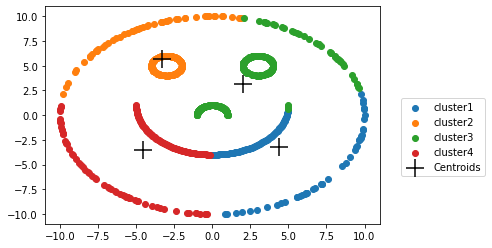

Number of clusters: 5
Converged at iteration  14


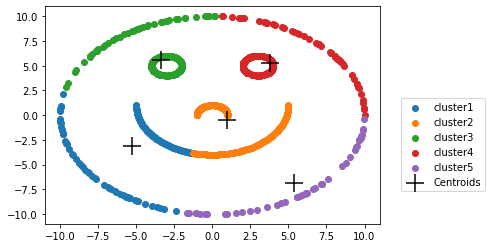

Number of clusters: 6
Converged at iteration  10


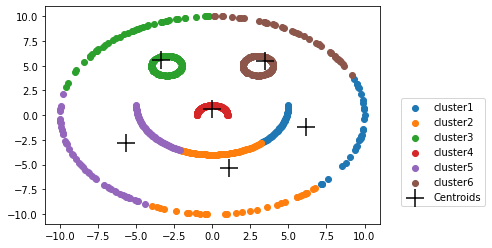

In [8]:
for K in [4,5,6] :  
    print("\033[1m"+'Number of clusters: ' + str(K)+ "\033[0m")
    Output,Centroids=kmeans(K,300,X)

    labels=['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']

    for k in range(K):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],label=labels[k])
    plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='black',label='Centroids',marker='+')
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()

(b) Implement k-means++ to initialize cluster centers usefully. [5 points]


The function **pp_initialization( )** has the implementation of kmeans++ is used to initialize the centroids. It makes sure that the centroids initialized are not very close to each other. It helps in reducing the number of iterations required to converge at times.


In [9]:
def pp_initialization(X,K):
    i=rd.randint(0,X.shape[0])
    Centroid_temp=np.array([X[i]])
    for k in range(1,K):
        Distance=np.array([]) 
        for x in X:
            Distance=np.append(Distance,np.min(np.sum((x-Centroid_temp)**2)))
        prob=Distance/np.sum(Distance)
        cummulative_probability=np.cumsum(prob)
        r=rd.random()
        i=0
        for j,p in enumerate(cummulative_probability):
            if r<p:
                i=j
                break
        Centroid_temp=np.append(Centroid_temp,[X[i]],axis=0)
    return Centroid_temp.T

**Visualizing the results of kmeans++ clustering for different values K (Number of clusters) :**<br>
It uses the same function as kmeans, this time pp_initialization() is used for better initialization of centroids.

Number of clusters: 4
Converged at iteration  10


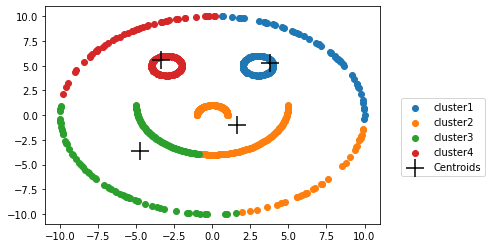

Number of clusters: 5
Converged at iteration  16


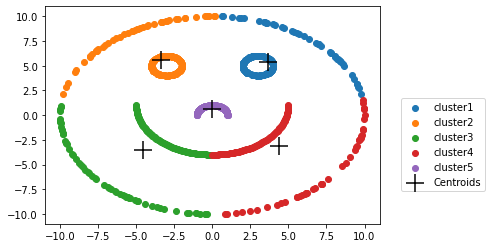

Number of clusters: 6
Converged at iteration  11


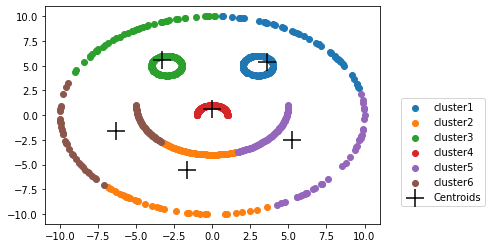

In [10]:
for K in [4,5,6] : 
    print("\033[1m"+'Number of clusters: ' + str(K)+ "\033[0m")
    Output,Centroids=kmeans(K,300,X,initialization='plus_plus')
    labels=['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']

    for k in range(K):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],label=labels[k])
    plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='black',label='Centroids',marker='+')
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()

**Conclusion:**
The clustering results obtained with kmeans and kmeans++ don't differ by much. Kmeans++ may converge faster at times when compared to vanilla kmeans because of better initialization of centroids. 

(c) What value of k gives you the best clustering? Are you happy with the quality of the clustering? [5 points]

In [11]:
LOSS_array=np.array([])
for K in range(1,10):
    Output,Centroids=kmeans(K,100,X)
    loss=cal_loss(Output, Centroids)
    LOSS_array=np.append(LOSS_array,loss)

Converged at iteration  2
Converged at iteration  29
Converged at iteration  7
Converged at iteration  20
Converged at iteration  13
Converged at iteration  28
Converged at iteration  16
Converged at iteration  26
Converged at iteration  29


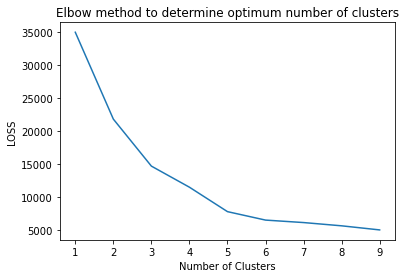

In [12]:
K_array=np.arange(1,10,1)
plt.plot(K_array,LOSS_array)
plt.xlabel('Number of Clusters')
plt.ylabel('LOSS')
plt.title('Elbow method to determine optimum number of clusters')
plt.show()

**Results:** From the above plot, it can be observed that the loss keeps on decreasing with increasing value of K. Elbow point is at either 4 or 5. Therefore, we can consider the optimal value of K as 5.
<br>
<br>
The clustering results aren't satisfactory with kmeans or kmeans++, though we get an elbow point at K=5, but the divisions aren't the best as visible from the graphs.

**Plotting the clustering results with the optimal k value:**

Number of clusters: 5
Converged at iteration  14


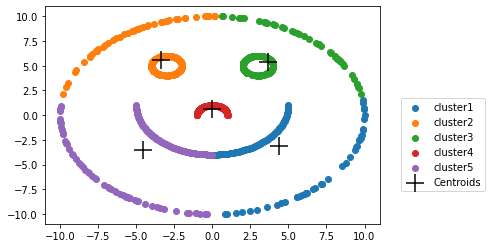

In [13]:
for K in [5] : 
    print("\033[1m"+'Number of clusters: ' + str(K)+ "\033[0m")
    Output,Centroids=kmeans(K,300,X,initialization='plus_plus')
    labels=['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']

    for k in range(K):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],label=labels[k])
    plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='black',label='Centroids',marker='+')
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()

(d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm [15 points]

**Gaussian Kernel:**
Gaussian kernel is a general purpose kernel, with equation :
$$
k(x_{i},x_{j})=exp \ (\frac{||x_{i}-x_{j}||^{2}}{2 \sigma^2})$$ <br>
<br>
The above equation is used to generate kernel matrix.

In [14]:
from math import exp 

In [15]:
def squaredDistance(v1, v2):
    sum = 0 
    dim = len(v1) 
    
    for i in range(dim):
        sum += (v1[i] - v2[i]) * (v1[i] - v2[i]) 
        
    return sum

In [16]:
#Calculates the Kernel Matrix
def kernel_matrix(data, sigma):
    nData = len(data)
    kmatrix = [[0] * nData for i in range(nData)] # nData x nData matrix
    #The matrix is symmetric
    for i in range(nData):
        for j in range(i,nData):
            if i != j: # diagonal element of the matrix will be 0
                # Gaussian kernel: K(xi,xj) = e ( (-|xi-xj|**2) / (2sigma**2))
                square_dist = squaredDistance(data[i],data[j])
                base = 2.0 * sigma**2
                kmatrix[i][j] = exp(-square_dist/base)
                kmatrix[j][i] = kmatrix[i][j]
    return kmatrix 

In [17]:
def kernelized_kmeans(K,iterations,X,kmatrix,tol=1e-06) :
    m=kmatrix.shape[0] #number of training examples
    n=kmatrix.shape[1] 
    Centroids=pp_initialization(kmatrix,K) #calling the kmeans++ for initialization
    #print(Centroids)
    flag=0
    for itr in range(iterations):
        euclidian_dist=np.array([]).reshape(m,0)
        for k in range(K):
            temp_dist=np.sum((kmatrix-Centroids[:,k])**2,axis=1)
            euclidian_dist=np.c_[euclidian_dist,temp_dist]
        C=np.argmin(euclidian_dist,axis=1)+1

        Y={}
        Y2={}
        for k in range(K):
            Y[k+1]=np.array([]).reshape(1000,0)
            Y2[k+1]=np.array([]).reshape(2,0)   
            
        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],kmatrix[i]]
            Y2[C[i]]=np.c_[Y2[C[i]],X[i]]

        for k in range(K):
            Y[k+1]=Y[k+1].T
            Y2[k+1]=Y2[k+1].T

        for k in range(K):
            Centroids[:,k]=np.mean(Y[k+1],axis=0)
        Output=Y2
        #Convergence Chcek
        if (flag==0) :
            #print(i)
            loss_prev=cal_loss(Y, Centroids)
            flag=1
        else :
            new_loss=cal_loss(Y, Centroids)
            if abs(loss_prev-new_loss) <= tol :
                print('Converged at iteration ',itr+1)
                break
            loss_prev=new_loss
    return Output,Centroids

In [18]:
data=[]
for i in range(len(X)) :
    data.append(list(X[i]))

In [19]:
kernel_matrix=np.array(kernel_matrix(data,3.90))

Using the Kernel Matrix created above in the kmeans algorithm for better results.

Converged at iteration  8


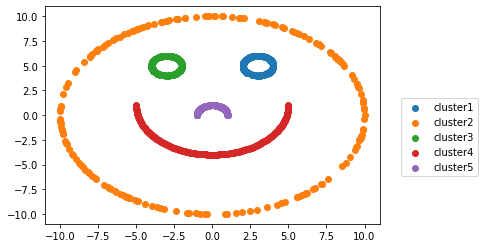

In [20]:
for K in [5] :    
    Output,Centroids=kernelized_kmeans(K,150,X,kernel_matrix)
    labels=['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']
    for k in range(K):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],label=labels[k])
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()

*Note: The results from kernelized kmeans may not be perfect for some runs. Kindly, re-run in such cases*

### Q2. Expectation-Maximization

We saw how to use EM to learn parameters for Gaussian mixture models last week. Specifically, for a GMM described by the set of parameters $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$, we saw that the E-step boils down to figuring out the expected assignment of clusters based on a responsibility judgment proportional to $\pi_k~N(\mu_k, \Sigma_k)$, given curent parameter estimates, followed by using GDA MLE updates assuming the current expected assignment in the M-step to update parameter values.

(a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ are known, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

**Derivation for Gaussian Mixture Model:** <br>
Let there be K gaussian distributions: $$
\theta=\left\{\mu_{1}, \mu_{2}, \ldots \mu_{k}, \sigma_{1}^{2}, \sigma_{2}^{2}, \ldots \sigma_{K}^{2}\right\}
$$ <br>
Let, $$
X=\left\{x_{1}, x_{2}, \ldots x_{n}\right\} \text { be } n \text { i.i.ds }  $$
and, $$
z=\left\{z_{1}, z_{2}, \ldots z_{n}\right\} \text {be the corresponding latent variables}
$$ <br>
The mixture weights are known and are considered to be fixed as $ \left\{\pi_{1}, \pi_{2}, \ldots \pi_{k}\right\}$ <br>

<br><br>
Now, for a data point $x_{n} :$ <br> 
$ P(x_{n},z_{n} | \theta) = P(x_{n}|z_{n} , \theta)P(z_{n}|\theta) $<br>
$ \quad \quad \quad \quad \ =\prod_{k=1}^{K}[ N(x_{n}|\mu_{k},\sigma_{k}^{2}I_{d})\pi_{k}]^{{z}_{nk}} \text{ ,where }{z}_{nk} = 1 \text { if } x_{n} \in \ k^{th} cluster  $
<br><br>
Considering all the data points, <br>
$ P(X,z|\theta) \ = \ \prod_{n=1}^{N}\prod_{k=1}^{K} [N(x_{n}|\mu_{k}, \sigma_{k}^{2}I_{d}]^{{z}_{nk}} $
<br><br>
Taking log :<br>
$\begin{aligned} log[P(X,z|\theta)] \ =\ \sum_{n=1}^{N} \sum_{k=1}^{K} E[z_{nk}] log [N(x_{n}|\mu_{k},\sigma_{k}^{2}I_{d})\pi_{k}] \end{aligned}$
$$
\begin{aligned}
&=\sum_{n=1}^{N} \sum_{k=1}^{K} E[z_{n k}][\log \pi_{k}+\log \frac{1}{(2 \pi)^{\frac{d}{2}}\sigma_{k}^{d}} \operatorname{exp}(\frac{-\|x_{n}-\mu_k\|^{2}}{2 \sigma_{k^{2}}})] \\
&=\sum_{n=1}^{N} \sum_{k=1}^{K} E[z_{n k}][\log \pi_{k}-\frac{\|x_{n}-\mu_{k}\|^{2}}{2 \sigma_{k}{ }^{2}}-\frac{d}{2} \log (2 \pi)-d \log \sigma_{k}]   -- \ i
\end{aligned}
$$

Estimating $Z_{nk}$ :
$$  P(z_{nk}=1|x_{n},\hat \theta) = \frac {P(x_{n}|z_{nk}=1,\hat \theta) \ P(z_{nk}=1|\hat \theta)}{\sum_{k^{'}=1}^{K} P(x_{n}|z_{nk^{'}=1}|\hat \theta) \ P(z_{nk^{'}=1}|\hat \theta)}$$<br><br>
$$ 
\begin{aligned}
&E\left[z_{n k}^{t}\right]=\frac{\pi_{k} N\left(x_{n} \mid \hat{\mu}_{k}, \hat{\sigma}_{k}^{2}I_{d}\right)}{\sum_{k=1}^{k} \pi_{k} N\left(x_n | \hat{\mu_{k}}, \hat{\sigma}_{k}^{2}I_{d}\right)} \quad \forall n, k \\
\end{aligned}
$$

Updating, $\hat \theta$ i.e. $\mu_{k}, \sigma^{2}_{k}$, with the $ Z_{nk}$ estimated above :
$$
\hat{\theta}=\operatorname{argmax}_{\theta} \sum_{n=1}^{N} \sum_{k=1}^{K} E[z_{n k}]\left[\log \pi_{k}-\frac{\left\|x_{n}-\mu_{k}\right\|^{2}}{2 \sigma_{k}^{2}}-\frac{d}{2} \log 2 \pi-d \log \sigma_{k}\right]
$$
<br><br>

Taking the derivative of equation (i) w.r.t $\mu_{k}$ : 
$$
\begin{aligned}
\frac{\partial P(x, z / \theta)}{\partial \mu_{k}} &=\sum_{n=1}^{N} E[z_{n k}]\left[\frac{2 *\left(x_{n}-\mu_{k}\right)}{2  \sigma_k^{2}}\right] \\
&\implies \sum_{n=1}^{N} E[z_{n k}] *\left(x_{n}-\mu_{k}\right) =  0 \\
&\implies \sum_{n=1}^{N} E[z_{n k}] * \mu_{k}=\sum_{n=1}^{N} E[z_{n k}] * x_{n}  \\
\mu_{k}=& \frac{\sum_{n=1}^{N} E[z_{n k}] *x_n}{\sum_{n=1}^{N} E[z_{nk}]}; \forall k\\
\end{aligned}
$$

Taking the derivative of equation (i) w.r.t $ \sigma_{k} $ :
$$
\begin{aligned}
\frac{\partial P(x, z / \theta)}{\partial \sigma_{k}} &= \sum_{n=1}^{N} E[z_{n k}] \left[\frac{\|x_n - \mu_k\|^2}{\sigma_k^3} - \frac{d}{\sigma_k}\right] \\
&\implies \sum_{n=1}^{N} E[z_{nk}] * \left[\frac{\|x_n - \mu_k\|^2}{\sigma_k^2} - d \right] = 0 \\
& \implies \sum_{n=1}^{N} E[z_{nk}]*d= \sum_{n=1}^{N} E[z_{nk}]*\frac{\|x_n - \mu_k\|^2}{\sigma_k^2} 
\end{aligned}
$$
$$
\begin{aligned}
& \quad \quad \quad \quad \ \quad  \implies d * \sum_{n=1}^{N} E[z_{n k}]=\frac{1}{\sigma_{k}{ }^{2}} \sum_{n =1}^{N} E[z_{n k}] *\left\|x_{n}-\mu_{k}\right\|^{2} \\
& \quad \quad \quad \sigma_{k}^{2}=\frac{\sum_{n=1}^{N} z_{n k} *\left\|x_{n}-\mu_{k}\right\|^{2}}{d * \sum_{n=1}^{N} E[z_{n k}]}
\end{aligned}
$$

Therefore, the final algorithm :

**E-step:**
$$
\begin{aligned}
&E[z_{n k}]^{(t+1)}=\frac{\pi_{k} N({x_n} | \mu_{k}^{(t)}, \sigma_{k}^{(t)^{2}} I_{d})}{\sum_{k=1}^{K} \pi_k N(x_n|\mu_{k}^{(t)}, \sigma_{k}^{(t)^{2}} I_{d})} \quad; \forall n, k
\end{aligned}
$$
**M-step:**
$$
\begin{aligned}
&\mu_{k}^{(t+1)}=\frac{\sum_{n=1}^{N} E[z_{nk}]^{(t+1)}*x_n}{\sum_{n=1}^{N} E[z_{nk}]^{(t+1)}} , \\
& \\
&{\sigma_{k}^{2}}^{(t+1)}=\frac{\sum_{n=1}^{N} E[z_{nk}]^{(t+1)}*\|x_n-\mu_k^{(t+1)}\|^2}{d*\sum_{n=1}^{N} E[z_{nk}]^{(t+1)}}
\end{aligned}
$$

(b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 

In [21]:
from scipy.stats import multivariate_normal 

In [22]:
def check_convergence(ll_latest,ll,thresh) :
    if (ll_latest - ll) < thresh and ll_latest > -np.inf :
        return 1
    return 0

In [23]:
# Computes the loglikelihood of the data for a Gaussian mixture model with the given parameters.    
def loglikelihood(data, weights, means, covs):
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        Z = np.zeros(num_clusters)
        
        for k in range(num_clusters):            
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Computes loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        log_sum= np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))
        ll += log_sum
        
    return ll

In [24]:
def cal_resp(data, weights, means, covariances):
    number_data = len(data)
    number_clusters = len(means)
    resp = np.zeros((number_data, number_clusters))
    
    for i in range(number_data):
        for k in range(number_clusters):
            resp[i, k] = weights[k]*multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
    
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

In [25]:
def cal_mean(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        #Updating means for each cluster
        weighted_sum = 0.
        for i in range(num_data):
            weighted_sum += data[i] * resp[i][k]
        means[k] = weighted_sum / counts[k]

    return means

In [26]:
def cal_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        
        weighted_sum=np.zeros((num_dim,num_dim))
        for i in range(num_data):
            weighted_sum += resp[i][k]*np.dot(data[i] - means[k], data[i] - means[k])
        
        covariances[k] = (weighted_sum*np.identity(num_dim)) / (counts[k])
        
    return covariances

In [27]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-8):
    
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    num_data = len(data) 
    num_dim = len(data[0])
    num_clusters = len(means) #Number of clusters
    
    
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        
        # E-step:
        resp = cal_resp(data, weights, means, covariances)

        # M-step:
        counts = np.sum(resp, axis=0)
        means = cal_mean(data, resp, counts)
        covariances = cal_covariances(data, resp, counts, means)
        
        # Computing the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Checking for convergence in log-likelihood of current iteration and previous iteration
        if check_convergence(ll_latest,ll,thresh):
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out
        

**Generating Synthetic data:**

In [28]:
def generate_synthetic_data(num_data, means, covariances, weights):
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [29]:
init_means = [
    [10, -5], # mean of cluster 1
    [0, 7], # mean of cluster 2
    [-10, -10]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.9, 0.], [0., .9]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4, 1/2, 1/4]  # weights of each cluster

# Generating the synthetic data
np.random.seed(1000)
data = generate_synthetic_data(150, init_means, init_covariances, init_weights)

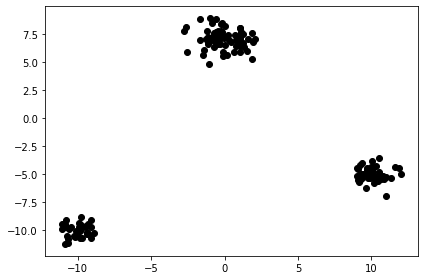

In [30]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update()
plt.tight_layout()

The functions below help in plotting the clustering :

In [31]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denominator = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denominator

In [32]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-12.0, 12.0, delta)
    y = np.arange(-12.0, 12.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z =bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update()
    plt.tight_layout()

**Performing clustering using the E-M algorithm:**

In [33]:
np.random.seed(500)

chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [[[1,0],[0,1]]] * 3
initial_weights = [1/3] * 3

results = EM(data, initial_means, initial_covs, initial_weights)


##### Plotting the initial clustering on the data:

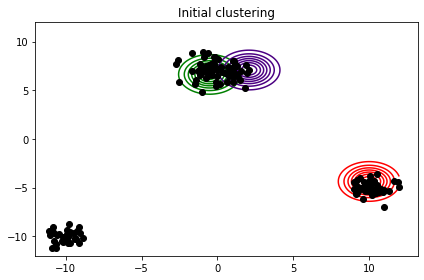

In [34]:
plot_contours(data, initial_means, initial_covs, 'Initial clustering')

**Plotting the clustering using the E-M Algorithm:**

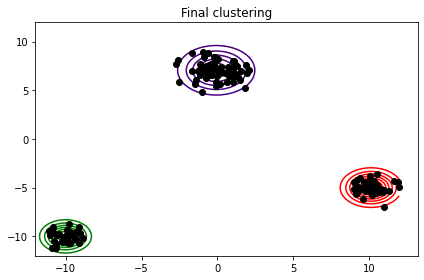

In [35]:
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clustering')
